## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [91]:
def draw_graph(mod, m):
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    my_x_ticks = np.arange(-1, 1, 0.2)
    my_y_ticks = np.arange(-1, 1, 0.2)
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,199,9))  
    ax.set_xticklabels(('-1', '-0.75', '-0.5', '-0.25', '0', '0.25', '0.5', '0.75', '1'))  
    ax.set_yticks(np.linspace(0,199,9))  
    ax.set_yticklabels( ('1', '0.75', '0.5', '0.25', '0','-0.25','-0.5','-0.75', '-1'))  
    
    plt.savefig("../Adaptive/loss_1.eps")
    plt.show()

In [92]:
model = DeepRitzNet(10)
model.load_state_dict(torch.load('../Adaptive/model.pkl'))

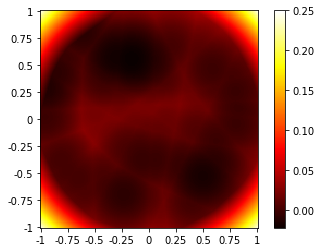

In [93]:
draw_graph(model, 10)

In [2]:
def cal_loss(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t += 1
    return mmm / t

In [3]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            if re[0] ** 2 + re[1] ** 2 < 1 :
                z[i, j] = mod(re.float()).item() + U_groundtruth(re)
                w[i, j] = U_groundtruth(re)
                t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [9]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

In [7]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

In [8]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [42]:
"""
Train with the grid
从初始化模型开始训练
"""

model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = MultiStepLR(optimizer, milestones=[300, 400], gamma=0.1)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
for k in range(iterations):
    n1 = 0
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y #+ gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss = gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
    loss /= n1
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if gamma < 500:
        gamma = gamma * 1.01
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss(model))
    if cal_loss(model) < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    
    #scheduler.step()
    optimizer.step()
    

0  epoch, loss:  0.003757581
0  epoch, regularization loss:  0.0014568424
0  loss to real solution:  0.12585706354720796
1  epoch, loss:  0.0017227847
1  epoch, regularization loss:  0.0049991105
1  loss to real solution:  0.12494390999197574
2  epoch, loss:  -0.006674614
2  epoch, regularization loss:  0.010949647
2  loss to real solution:  0.12307167222837155
3  epoch, loss:  -0.02460782
3  epoch, regularization loss:  0.020303011
3  loss to real solution:  0.12117159876601107
4  epoch, loss:  -0.05633974
4  epoch, regularization loss:  0.034012053
4  loss to real solution:  0.11934473653698269
5  epoch, loss:  -0.10548175
5  epoch, regularization loss:  0.053524155
5  loss to real solution:  0.12056768686058446
6  epoch, loss:  -0.15654023
6  epoch, regularization loss:  0.07246395
6  loss to real solution:  0.1259098148690926
7  epoch, loss:  -0.22613847
7  epoch, regularization loss:  0.09942548
7  loss to real solution:  0.14328349177668728
8  epoch, loss:  -0.30700633
8  epoch, 

68  epoch, loss:  -0.31303304
68  epoch, regularization loss:  0.12824012
68  loss to real solution:  0.24474276994777264
69  epoch, loss:  -0.3133995
69  epoch, regularization loss:  0.12943059
69  loss to real solution:  0.24598872680372746
70  epoch, loss:  -0.31168887
70  epoch, regularization loss:  0.12944536
70  loss to real solution:  0.24600985631490435
71  epoch, loss:  -0.30720967
71  epoch, regularization loss:  0.12664717
71  loss to real solution:  0.24300328696847337
72  epoch, loss:  -0.30309236
72  epoch, regularization loss:  0.124337934
72  loss to real solution:  0.2402248733258323
73  epoch, loss:  -0.29955977
73  epoch, regularization loss:  0.122458495
73  loss to real solution:  0.23763043790001578
74  epoch, loss:  -0.2968656
74  epoch, regularization loss:  0.120770946
74  loss to real solution:  0.23512396680772105
75  epoch, loss:  -0.2950242
75  epoch, regularization loss:  0.119422145
75  loss to real solution:  0.23281713088417352
76  epoch, loss:  -0.293

135  epoch, loss:  -0.18511675
135  epoch, regularization loss:  0.068070784
135  loss to real solution:  0.10102990307608603
136  epoch, loss:  -0.16735941
136  epoch, regularization loss:  0.05208835
136  loss to real solution:  0.08307033642695265
137  epoch, loss:  -0.18566303
137  epoch, regularization loss:  0.06912157
137  loss to real solution:  0.10043656193175118
138  epoch, loss:  -0.19797675
138  epoch, regularization loss:  0.08361306
138  loss to real solution:  0.11340510102138643
139  epoch, loss:  -0.17639354
139  epoch, regularization loss:  0.061338186
139  loss to real solution:  0.0933985694054622
140  epoch, loss:  -0.16324563
140  epoch, regularization loss:  0.048479207
140  loss to real solution:  0.08109942940653711
141  epoch, loss:  -0.18086724
141  epoch, regularization loss:  0.06564093
141  loss to real solution:  0.10021935331093156
142  epoch, loss:  -0.20779179
142  epoch, regularization loss:  0.096356556
142  loss to real solution:  0.125098309712394

KeyboardInterrupt: 

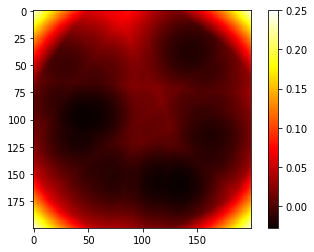

0.012661244662244994


In [42]:
validate(the_model)

In [56]:
relative_err(the_model)

0.013054753003282139

In [45]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(the_model.state_dict(), PATH)

In [59]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
the_model = DeepRitzNet(m)
the_model.load_state_dict(torch.load(PATH))

In [61]:
#训练the_model
train(the_model, initial_lr=0.001*learning_rate)

0  epoch, loss:  -0.08616357
0  epoch, regularization loss:  0.001109431
0  loss to real solution:  0.01288790036244406
1  epoch, loss:  -0.086388744
1  epoch, regularization loss:  0.001135872
1  loss to real solution:  0.012953969863066704
2  epoch, loss:  -0.086642124
2  epoch, regularization loss:  0.0011608076
2  loss to real solution:  0.013017922797003725
3  epoch, loss:  -0.086860955
3  epoch, regularization loss:  0.0011867222
3  loss to real solution:  0.013086209406423398
4  epoch, loss:  -0.087096505
4  epoch, regularization loss:  0.0012130924
4  loss to real solution:  0.013155625851591283
5  epoch, loss:  -0.0873614
5  epoch, regularization loss:  0.001240245
5  loss to real solution:  0.013228115335921364
6  epoch, loss:  -0.087626286
6  epoch, regularization loss:  0.0012681441
6  loss to real solution:  0.013305461368376788
7  epoch, loss:  -0.087859295
7  epoch, regularization loss:  0.0012967697
7  loss to real solution:  0.013386393407916702
8  epoch, loss:  -0.088

66  epoch, loss:  -0.10226144
66  epoch, regularization loss:  0.004440409
66  loss to real solution:  0.02316192014999323
67  epoch, loss:  -0.102524176
67  epoch, regularization loss:  0.004525743
67  loss to real solution:  0.023375456520982052
68  epoch, loss:  -0.1027654
68  epoch, regularization loss:  0.0046126186
68  loss to real solution:  0.023590065808158155
69  epoch, loss:  -0.10296665
69  epoch, regularization loss:  0.0047009694
69  loss to real solution:  0.023805995535620482
70  epoch, loss:  -0.10321301
70  epoch, regularization loss:  0.004790906
70  loss to real solution:  0.024022872354056615
71  epoch, loss:  -0.10343874
71  epoch, regularization loss:  0.00488242
71  loss to real solution:  0.024239845191550733
72  epoch, loss:  -0.10369218
72  epoch, regularization loss:  0.0049755448
72  loss to real solution:  0.024456973604833905
73  epoch, loss:  -0.10391434
73  epoch, regularization loss:  0.0050702784
73  loss to real solution:  0.024674068861835582
74  ep

132  epoch, loss:  -0.116253145
132  epoch, regularization loss:  0.014028709
132  loss to real solution:  0.03668615758227376
133  epoch, loss:  -0.116463035
133  epoch, regularization loss:  0.014248351
133  loss to real solution:  0.03686075079862705
134  epoch, loss:  -0.11662215
134  epoch, regularization loss:  0.014470998
134  loss to real solution:  0.037034886918267194
135  epoch, loss:  -0.116809085
135  epoch, regularization loss:  0.014696702
135  loss to real solution:  0.0372086085843886
136  epoch, loss:  -0.11695361
136  epoch, regularization loss:  0.01492541
136  loss to real solution:  0.037381432731051864
137  epoch, loss:  -0.11716737
137  epoch, regularization loss:  0.015157132
137  loss to real solution:  0.03755345164004623
138  epoch, loss:  -0.11732294
138  epoch, regularization loss:  0.015391821
138  loss to real solution:  0.03772470469643443
139  epoch, loss:  -0.11747927
139  epoch, regularization loss:  0.015629478
139  loss to real solution:  0.0378950

197  epoch, loss:  -0.12418908
197  epoch, regularization loss:  0.033886164
197  loss to real solution:  0.04446089530872757
198  epoch, loss:  -0.124207474
198  epoch, regularization loss:  0.034263473
198  loss to real solution:  0.04450229059078298
199  epoch, loss:  -0.12427796
199  epoch, regularization loss:  0.034641664
199  loss to real solution:  0.04454041351076103
200  epoch, loss:  -0.12430341
200  epoch, regularization loss:  0.035020873
200  loss to real solution:  0.044575496162632226
201  epoch, loss:  -0.124352604
201  epoch, regularization loss:  0.035400815
201  loss to real solution:  0.04460725758045045
202  epoch, loss:  -0.12436161
202  epoch, regularization loss:  0.035781376
202  loss to real solution:  0.04463571324034131
203  epoch, loss:  -0.12439477
203  epoch, regularization loss:  0.03616254
203  loss to real solution:  0.04466085169093014
204  epoch, loss:  -0.12440326
204  epoch, regularization loss:  0.036544085
204  loss to real solution:  0.04468256

263  epoch, loss:  -0.11839608
263  epoch, regularization loss:  0.054712404
263  loss to real solution:  0.03879604677487028
264  epoch, loss:  -0.118154615
264  epoch, regularization loss:  0.05485295
264  loss to real solution:  0.038565128654529
265  epoch, loss:  -0.11789324
265  epoch, regularization loss:  0.054985534
265  loss to real solution:  0.03833018923304084
266  epoch, loss:  -0.117659636
266  epoch, regularization loss:  0.055113427
266  loss to real solution:  0.03809302196816994
267  epoch, loss:  -0.117402315
267  epoch, regularization loss:  0.055236567
267  loss to real solution:  0.03785343884655129
268  epoch, loss:  -0.11717701
268  epoch, regularization loss:  0.0553509
268  loss to real solution:  0.037609644445958955
269  epoch, loss:  -0.116914526
269  epoch, regularization loss:  0.05545658
269  loss to real solution:  0.037361761952519744
270  epoch, loss:  -0.11668094
270  epoch, regularization loss:  0.05555333
270  loss to real solution:  0.03710976103

328  epoch, loss:  -0.09748139
328  epoch, regularization loss:  0.048716724
328  loss to real solution:  0.0190405833663664
329  epoch, loss:  -0.09712065
329  epoch, regularization loss:  0.048431247
329  loss to real solution:  0.018754614760254695
330  epoch, loss:  -0.09671958
330  epoch, regularization loss:  0.048140824
330  loss to real solution:  0.018470420316101226
331  epoch, loss:  -0.09637774
331  epoch, regularization loss:  0.047845703
331  loss to real solution:  0.018188982937496913
332  epoch, loss:  -0.09598065
332  epoch, regularization loss:  0.047547005
332  loss to real solution:  0.017911112887299675
333  epoch, loss:  -0.095650084
333  epoch, regularization loss:  0.04725292
333  loss to real solution:  0.01764003374185589
334  epoch, loss:  -0.09517723
334  epoch, regularization loss:  0.04694839
334  loss to real solution:  0.017372264139521892
335  epoch, loss:  -0.094838895
335  epoch, regularization loss:  0.04664447
335  loss to real solution:  0.0171144

393  epoch, loss:  -0.07527519
393  epoch, regularization loss:  0.029770873
393  loss to real solution:  0.013297568584561754
394  epoch, loss:  -0.07505845
394  epoch, regularization loss:  0.029644703
394  loss to real solution:  0.013368268808367955
395  epoch, loss:  -0.07482796
395  epoch, regularization loss:  0.029523212
395  loss to real solution:  0.013439251088636115
396  epoch, loss:  -0.07459139
396  epoch, regularization loss:  0.029406218
396  loss to real solution:  0.013509225600018783
397  epoch, loss:  -0.07433549
397  epoch, regularization loss:  0.02929428
397  loss to real solution:  0.013577999969004072
398  epoch, loss:  -0.07413131
398  epoch, regularization loss:  0.029187333
398  loss to real solution:  0.013647695906292612
399  epoch, loss:  -0.07391829
399  epoch, regularization loss:  0.029084211
399  loss to real solution:  0.013721713099832344


In [62]:
# Calculate time for grid method
def train(mod, initial_lr=learning_rate, milestones=[400], gamma=0.1, iterations=iterations, mm=1):
    optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                    n1 += 1
                    x_input = torch.tensor(x_input).float()
                    y = mod(x_input)

                    x1 = torch.zeros(m)
                    x2 = torch.zeros(m)
                    x1[0] = 0.0001
                    x2[1] = 0.0001
                    x_input_1 = x_input.float() + x1
                    x_input_2 = x_input.float() + x2
                    x_input_3 = x_input.float() - x1
                    x_input_4 = x_input.float() - x2
                    x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                    x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                    x_input_2_grad_x = (mod(x_input_1) + the_model(x_input_3) - 2 * y) / 0.0001**2
                    x_input_2_grad_y = (mod(x_input_2) + the_model(x_input_4) - 2 * y) / 0.0001**2

                    loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) + y #+ gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                    #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                    #loss = gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            theta = t / n2 * (2 * pi)
            x_input = np.zeros(m)
            x_input[0] = cos(theta)
            x_input[1] = sin(theta)
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += y**2 
        regularization *= mm / n2
        if gamma < 500:
            gamma = gamma * 1.01
        if mm < 500:
            mm = mm * 1.01

        #print loss
        print(k, " epoch, loss: ", loss.data[0].numpy())
        print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
        print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(the_model) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)